In [ ]:
import numpy as np
import keras
from keras.models import Model
from keras.datasets.cifar10 import load_data
from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.applications.vgg16 import preprocess_input 
from keras.models import Sequential
from keras.layers import Flatten, MaxPool2D
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score

In [ ]:
(x_train, y_train), (x_test, y_test) = load_data()

train_index = np.where(y_train.ravel() >= 4)
test_index = np.where(y_test.ravel() >= 4)

x_train = x_train[train_index]
y_train = y_train[train_index]
x_test = x_test[test_index]
y_test = y_test[test_index]

x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)
img_shape = x_train[0].shape

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
print("train shape: ", x_train.shape)
print("test shape: ", x_test.shape)
print("train target shape: ", y_train.shape)
print("test target shape: ", y_test.shape)

train shape:  (30000, 32, 32, 3)
test shape:  (6000, 32, 32, 3)
train target shape:  (30000, 1)
test target shape:  (6000, 1)


## **Primo taglio: FC layers**

In [ ]:

model = VGG16(weights='imagenet', input_shape=img_shape, include_top=False) 
model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________________________

In [ ]:
output = model.get_layer('block5_pool').output
output = Flatten()(output)
new_model = Model(model.input, output)
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

**Mio dataset cifar10**

In [ ]:
x_train_features = new_model.predict(x_train) 
x_test_features = new_model.predict(x_test) 

In [ ]:
print("train shape: ", x_train_features.shape)
print("test shape: ", x_test_features.shape)

train shape:  (30000, 512)
test shape:  (6000, 512)


In [ ]:
np.save('x_train_taglio_fc.npy', x_train_features)
np.save('x_test_taglio_fc.npy', x_test_features)

In [ ]:
np.save('y_train_taglio_fc.npy', to_categorical(y_train))
np.save('y_test_taglio_fc.npy', to_categorical(y_test))

## **Esperimenti**

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
split = 0.8

x_features = np.load('x_train_taglio_fc.npy')
x_features_test = np.load('x_test_taglio_fc.npy')
y_features = np.load('y_train_taglio_fc.npy')
y_features_test = np.load('y_test_taglio_fc.npy')

splitat = int(len(x_features) * split)
x_features_train = x_features[:splitat]
y_features_train = y_features[:splitat]

x_features_val = x_features[splitat:]
y_features_val = y_features[splitat:]

In [ ]:
print("train shape: ", x_features_train.shape)
print("test shape: ", x_features_test.shape)

train shape:  (24000, 512)
test shape:  (6000, 512)


In [ ]:
print("train shape: ", x_features_train.shape)
print("test shape: ", x_features_test.shape)

train shape:  (24000, 512)
test shape:  (6000, 512)


In [ ]:
y_features_test = np.argmax(y_features_test, axis=1)
y_features_val = np.argmax(y_features_val, axis=1)
y_features_train = np.argmax(y_features_train, axis=1)
y_features_train.shape

(24000,)

In [ ]:
from sklearn.svm import LinearSVC, SVC

svm = LinearSVC(verbose=2, max_iter=1000, C=0.1)
svm.fit(x_features_train, y_features_train) 


[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=2)

In [ ]:
x_features_test.shape

(6000, 512)

In [ ]:
x_features_train.shape

(24000, 512)

## Performance-train

In [ ]:

predictions_train = svm.predict(x_features_train)

print(classification_report(y_features_train, predictions_train))

              precision    recall  f1-score   support

           4       0.59      0.72      0.64      4003
           5       0.77      0.63      0.69      3977
           6       0.79      0.69      0.74      4020
           7       0.70      0.71      0.71      4024
           8       0.88      0.81      0.84      3998
           9       0.78      0.90      0.84      3978

    accuracy                           0.74     24000
   macro avg       0.75      0.74      0.74     24000
weighted avg       0.75      0.74      0.74     24000



In [ ]:

acc_train1= accuracy_score(y_features_train, predictions_train)
acc_train1

0.7432083333333334

In [ ]:

predictions_val = svm.predict(x_features_val)
print(classification_report(y_features_val, predictions_val))


              precision    recall  f1-score   support

           4       0.55      0.68      0.61       997
           5       0.73      0.58      0.64      1023
           6       0.77      0.67      0.72       980
           7       0.66      0.67      0.67       976
           8       0.87      0.80      0.83      1002
           9       0.76      0.88      0.82      1022

    accuracy                           0.71      6000
   macro avg       0.72      0.71      0.71      6000
weighted avg       0.72      0.71      0.71      6000



In [ ]:
acc_val1= accuracy_score(y_features_val, predictions_val)
acc_val1

0.7146666666666667

## TEST

In [ ]:

predictions_test = svm.predict(x_features_test)
print(classification_report(y_features_test, predictions_test))

              precision    recall  f1-score   support

           4       0.58      0.69      0.63      1000
           5       0.74      0.62      0.67      1000
           6       0.76      0.68      0.72      1000
           7       0.69      0.69      0.69      1000
           8       0.88      0.79      0.83      1000
           9       0.78      0.90      0.83      1000

    accuracy                           0.73      6000
   macro avg       0.74      0.73      0.73      6000
weighted avg       0.74      0.73      0.73      6000



In [ ]:
acc_test1= accuracy_score(y_features_test, predictions_test)
acc_test1

0.7296666666666667

### **Secondo Taglio** 

In [ ]:
from tensorflow.keras.models import Model
base_model = VGG16(weights = 'imagenet', input_shape=img_shape, include_top=False )
model2 = Model(inputs = base_model.input, outputs = base_model.get_layer('block4_pool').output)
output = model2.get_layer('block4_pool').output
output = Flatten()(output)
model2 = Model(model2.input, output)
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [ ]:
block4_pool_train_features = model2.predict(x_train)
block4_pool_test_features = model2.predict(x_test)
print(block4_pool_train_features.shape)
print(block4_pool_test_features.shape)
print(block4_pool_train_features)
print(block4_pool_test_features)

(30000, 2048)
(6000, 2048)
[[  0.          0.          0.        ...   0.          0.
    0.       ]
 [507.4358      0.        430.5692    ...   7.1725945   0.
  391.38397  ]
 [ 43.580486    0.        326.1762    ...  72.45773    17.934416
    0.       ]
 ...
 [  0.          0.        332.96362   ... 136.2713      0.
  207.31445  ]
 [  0.         51.55373   529.49603   ...   0.          0.
  142.28122  ]
 [270.04453     0.        118.73401   ...   0.          0.
    0.       ]]
[[  0.         0.       146.5086   ...   0.         0.         0.      ]
 [493.815      0.       655.06305  ...   0.         0.       171.5757  ]
 [106.02412    0.        30.21217  ...   0.         0.        76.36065 ]
 ...
 [  8.164804   0.         0.       ...   0.         0.       291.08743 ]
 [110.20189    0.       100.849205 ...   0.         0.         0.      ]
 [289.20325  252.82713  553.81635  ...  97.59216    0.       551.13043 ]]


In [ ]:
np.save('x_train_taglio_block4pool.npy', block4_pool_train_features)
np.save('x_test_taglio_block4pool.npy', block4_pool_test_features) 

In [ ]:
np.save('y_train_taglio_block4pool.npy', to_categorical(y_train))
np.save('y_test_taglio_block4pool.npy', to_categorical(y_test)) 

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
split = 0.8

x_features = np.load('x_train_taglio_block4pool.npy')
x_features_test = np.load('x_test_taglio_block4pool.npy')
y_features = np.load('y_train_taglio_block4pool.npy')
y_features_test = np.load('y_test_taglio_block4pool.npy')

splitat = int(len(x_features) * split)
x_features_train = x_features[:splitat]
y_features_train = y_features[:splitat]

x_features_val = x_features[splitat:]
y_features_val = y_features[splitat:]

In [ ]:
print("train shape: ", x_features_train.shape)
print("test shape: ", x_features_test.shape)

train shape:  (24000, 2048)
test shape:  (6000, 2048)


In [ ]:
print("train shape: ", x_features_train.shape)
print("test shape: ", x_features_test.shape)

train shape:  (24000, 2048)
test shape:  (6000, 2048)


In [ ]:
y_features_test = np.argmax(y_features_test, axis=1)
y_features_val = np.argmax(y_features_val, axis=1)
y_features_train = np.argmax(y_features_train, axis=1)
y_features_train.shape

(24000,)

In [ ]:
from sklearn.svm import LinearSVC, SVC

svm2 = LinearSVC(verbose=1, max_iter=1000, C= 0.1)
svm2.fit(x_features_train, y_features_train) 


[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=1)

In [ ]:

predictions_train2 = svm2.predict(x_features_train)
print(classification_report(y_features_train, predictions_train2))

              precision    recall  f1-score   support

           4       0.96      0.85      0.90      4003
           5       0.90      0.94      0.92      3977
           6       0.98      0.99      0.98      4020
           7       0.90      0.94      0.92      4024
           8       0.99      1.00      1.00      3998
           9       1.00      1.00      1.00      3978

    accuracy                           0.95     24000
   macro avg       0.95      0.95      0.95     24000
weighted avg       0.95      0.95      0.95     24000



In [ ]:
acc_train2= accuracy_score(y_features_train, predictions_train2)
acc_train2

0.952875

In [ ]:

predictions_val2 = svm2.predict(x_features_val)
print(classification_report(y_features_val, predictions_val2))

              precision    recall  f1-score   support

           4       0.79      0.69      0.74       997
           5       0.78      0.82      0.80      1023
           6       0.85      0.86      0.86       980
           7       0.78      0.82      0.80       976
           8       0.92      0.93      0.92      1002
           9       0.91      0.91      0.91      1022

    accuracy                           0.84      6000
   macro avg       0.84      0.84      0.84      6000
weighted avg       0.84      0.84      0.84      6000



In [ ]:
acc_val2= accuracy_score(y_features_val, predictions_val2)
acc_val2

0.8385

In [ ]:
predictions_test2 = svm2.predict(x_features_test)
print(classification_report(y_features_test, predictions_test2))

              precision    recall  f1-score   support

           4       0.80      0.69      0.74      1000
           5       0.78      0.80      0.79      1000
           6       0.83      0.86      0.85      1000
           7       0.78      0.83      0.80      1000
           8       0.92      0.92      0.92      1000
           9       0.92      0.92      0.92      1000

    accuracy                           0.84      6000
   macro avg       0.84      0.84      0.84      6000
weighted avg       0.84      0.84      0.84      6000



In [ ]:
acc_test2= accuracy_score(y_features_test, predictions_test2)
acc_test2

0.8376666666666667

### **TERZO TAGLIO**

In [ ]:
from tensorflow.keras.models import Model
base_model = VGG16(weights = 'imagenet', input_shape=img_shape, include_top=False )
model3 = Model(inputs = base_model.input, outputs = base_model.get_layer('block3_pool').output)
output = model3.get_layer('block3_pool').output
output = Flatten()(output)
model3 = Model(model3.input, output)
model3.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [ ]:
block2_pool_train_features = model3.predict(x_train)
block2_pool_test_features = model3.predict(x_test)
print(block2_pool_train_features.shape)
print(block2_pool_test_features.shape)


(30000, 4096)
(6000, 4096)


In [ ]:
np.save('x_train_taglio_block3pool.npy', block2_pool_train_features)
np.save('x_test_taglio_block3pool.npy', block2_pool_test_features)

np.save('y_train_taglio_block3pool.npy', to_categorical(y_train))
np.save('y_test_taglio_block3pool.npy', to_categorical(y_test))


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
split = 0.8

x_features = np.load('x_train_taglio_block3pool.npy')
x_features_test = np.load('x_test_taglio_block3pool.npy')
y_features = np.load('y_train_taglio_block3pool.npy')
y_features_test = np.load('y_test_taglio_block3pool.npy')

splitat = int(len(x_features) * split)
x_features_train = x_features[:splitat]
y_features_train = y_features[:splitat]

x_features_val = x_features[splitat:]
y_features_val = y_features[splitat:]

In [ ]:
y_features_test = np.argmax(y_features_test, axis=1)
y_features_val = np.argmax(y_features_val, axis=1)
y_features_train = np.argmax(y_features_train, axis=1)
y_features_train.shape

(24000,)

In [ ]:
from sklearn.svm import LinearSVC, SVC

svm3 = LinearSVC(verbose=1, max_iter=1000, C=0.1)
svm3.fit(x_features_train, y_features_train) 

[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=1)

In [ ]:

predictions_train3 = svm3.predict(x_features_train)
print(classification_report(y_features_train, predictions_train3))

              precision    recall  f1-score   support

           4       1.00      1.00      1.00      4003
           5       1.00      1.00      1.00      3977
           6       1.00      1.00      1.00      4020
           7       1.00      1.00      1.00      4024
           8       1.00      1.00      1.00      3998
           9       1.00      1.00      1.00      3978

    accuracy                           1.00     24000
   macro avg       1.00      1.00      1.00     24000
weighted avg       1.00      1.00      1.00     24000



In [ ]:
acc_train3= accuracy_score(y_features_train, predictions_train3)
acc_train3

1.0

In [ ]:
predictions_val3 = svm3.predict(x_features_val)
print(classification_report(y_features_val, predictions_val3))

              precision    recall  f1-score   support

           4       0.78      0.77      0.77       997
           5       0.80      0.80      0.80      1023
           6       0.87      0.88      0.87       980
           7       0.83      0.81      0.82       976
           8       0.92      0.93      0.93      1002
           9       0.92      0.92      0.92      1022

    accuracy                           0.85      6000
   macro avg       0.85      0.85      0.85      6000
weighted avg       0.85      0.85      0.85      6000



In [ ]:
acc_val3= accuracy_score(y_features_val, predictions_val3)
acc_val3

0.8533333333333334

In [ ]:
predictions_test3 = svm3.predict(x_features_test)
print(classification_report(y_features_test, predictions_test3))

              precision    recall  f1-score   support

           4       0.76      0.74      0.75      1000
           5       0.79      0.79      0.79      1000
           6       0.85      0.87      0.86      1000
           7       0.83      0.82      0.82      1000
           8       0.91      0.93      0.92      1000
           9       0.92      0.92      0.92      1000

    accuracy                           0.84      6000
   macro avg       0.84      0.84      0.84      6000
weighted avg       0.84      0.84      0.84      6000



In [ ]:
acc_test3= accuracy_score(y_features_test, predictions_test3)
acc_test3

0.8443333333333334

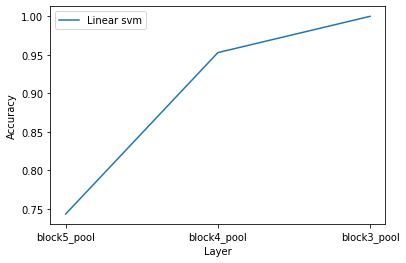

In [ ]:
import matplotlib.pyplot as plt
"""#Plot accuracy train"""

accuracy_train = [acc_train1,acc_train2,acc_train3]

x_plot = list(['block5_pool','block4_pool','block3_pool'])

plt.figure()
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.plot(x_plot, accuracy_train)

plt.legend(['Linear svm'])

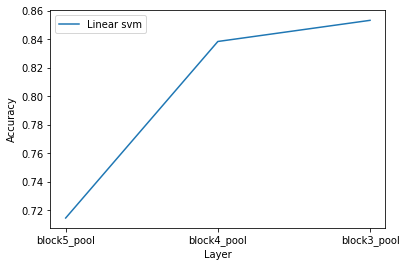

In [ ]:

"""#Plot accuracy val"""

accuracy_val = [acc_val1,acc_val2,acc_val3]

x_plot = list(['block5_pool','block4_pool','block3_pool'])

plt.figure()
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.plot(x_plot, accuracy_val)

plt.legend(['Linear svm'])

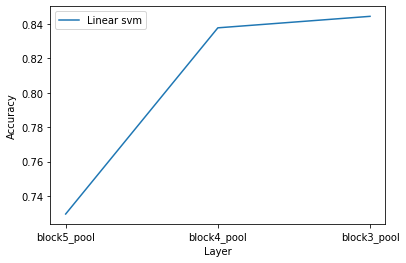

In [ ]:

"""#Plot accuracy test"""

accuracy_test = [acc_test1,acc_test2,acc_test3]

x_plot = list(['block5_pool','block4_pool','block3_pool'])

plt.figure()
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.plot(x_plot, accuracy_test)

plt.legend(['Linear svm'])